In [55]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
#plt.style.use('fivethirtyeight')

In [56]:
%matplotlib inline
from pylab import rcParams
import statsmodels.api as sm
from numpy.random import normal, seed
from scipy.stats import norm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import math
from sklearn.metrics import mean_squared_error
from random import random
import datetime

In [57]:
df = pd.read_excel("/content/patan_final.xlsx")

In [58]:
df.head()

,Date,Arrival,Price
0,2010-01-01,84.8,2755.0
1,2010-01-02,75.8,2750.0
2,2010-01-03,80.3,2752.5
3,2010-01-04,87.4,2750.0
4,2010-01-05,122.1,2770.0


In [59]:
df.describe()

,Date,Arrival,Price
count,5438,5438.000000,5438.000000
mean,2017-06-11 12:00:00,328.830241,4505.713616
min,2010-01-01 00:00:00,0.230000,2450.000000
25%,2013-09-21 06:00:00,135.543976,3650.000000
50%,2017-06-11 12:00:00,240.200000,4150.000000
75%,2021-03-01 18:00:00,429.172500,5382.666667
max,2024-11-20 00:00:00,2241.800000,7615.000000
std,NaN,296.937523,1161.928912


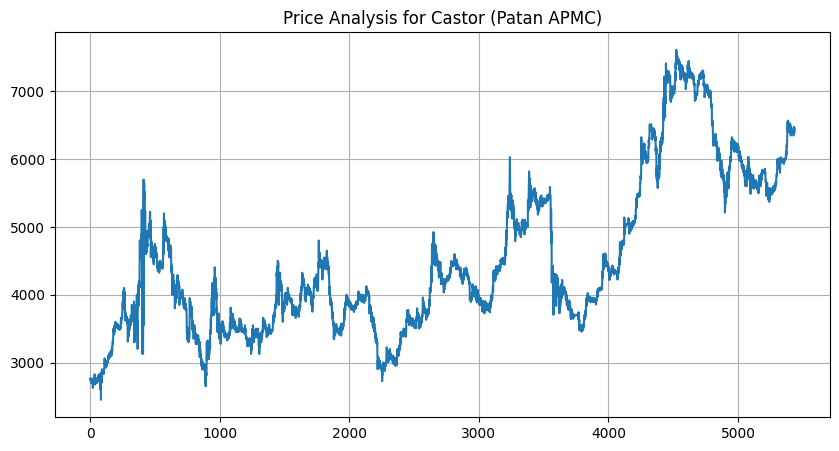

In [60]:
# Visualize
plt.figure(figsize=(10, 5))
plt.plot(df['Price'])
plt.title('Price Analysis for Castor (Patan APMC)')
plt.grid(True)
plt.show()

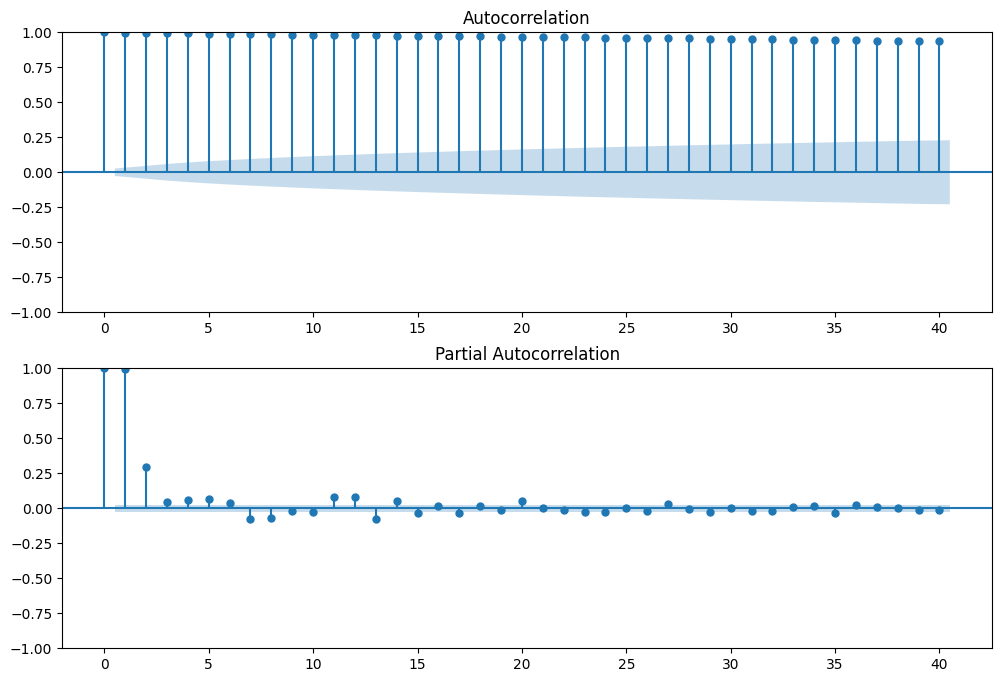

In [61]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df['Price'], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Price'], lags=40, ax=ax2)
plt.show()

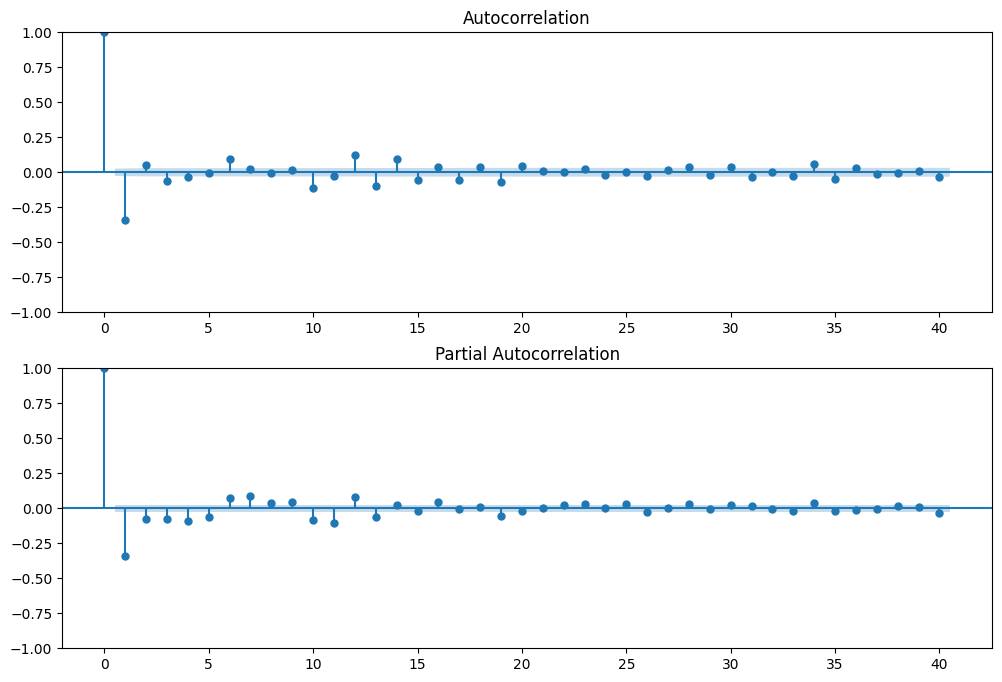

In [62]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#Plots with first order differenced Sales variable
fig = sm.graphics.tsa.plot_acf(df['Price'].diff().dropna(), lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df['Price'].diff().dropna(), lags=40, ax=ax2)
plt.show()

In [63]:
X = df[['Price', 'Arrival', 'Date']]
# X = X.values

In [64]:
X

,Price,Arrival,Date
0,2755.0,84.800,2010-01-01
1,2750.0,75.800,2010-01-02
2,2752.5,80.300,2010-01-03
3,2750.0,87.400,2010-01-04
4,2770.0,122.100,2010-01-05
...,...,...,...
5433,6475.0,238.050,2024-11-16
5434,6441.0,234.558,2024-11-17
5435,6450.0,217.580,2024-11-18
5436,6450.0,306.980,2024-11-19


In [65]:
train_size = int(len(df) * 0.8)
train_data_new = df.iloc[:train_size].reset_index(drop=True)  # Reset index for training data
test_data_new = df.iloc[train_size:].reset_index(drop=True)

In [66]:
train_data_new

,Date,Arrival,Price
0,2010-01-01,84.800000,2755.000000
1,2010-01-02,75.800000,2750.000000
2,2010-01-03,80.300000,2752.500000
3,2010-01-04,87.400000,2750.000000
4,2010-01-05,122.100000,2770.000000
...,...,...,...
4345,2021-11-24,214.800000,6440.000000
4346,2021-11-25,210.080000,6410.000000
4347,2021-11-26,173.180000,6385.000000
4348,2021-11-27,224.480000,6450.000000


In [67]:
test_data_new

,Date,Arrival,Price
0,2021-11-29,252.000,6410.0
1,2021-11-30,150.830,6390.0
2,2021-12-01,202.880,6450.0
3,2021-12-02,228.450,6445.0
4,2021-12-03,174.300,6395.0
...,...,...,...
1083,2024-11-16,238.050,6475.0
1084,2024-11-17,234.558,6441.0
1085,2024-11-18,217.580,6450.0
1086,2024-11-19,306.980,6450.0


In [68]:
# Extract Date index as a list
dates_list = test_data_new['Date'].tolist().copy()
print("Dates List:", dates_list)

Dates List: [Timestamp('2021-11-29 00:00:00'), Timestamp('2021-11-30 00:00:00'), Timestamp('2021-12-01 00:00:00'), Timestamp('2021-12-02 00:00:00'), Timestamp('2021-12-03 00:00:00'), Timestamp('2021-12-04 00:00:00'), Timestamp('2021-12-05 00:00:00'), Timestamp('2021-12-06 00:00:00'), Timestamp('2021-12-07 00:00:00'), Timestamp('2021-12-08 00:00:00'), Timestamp('2021-12-09 00:00:00'), Timestamp('2021-12-10 00:00:00'), Timestamp('2021-12-11 00:00:00'), Timestamp('2021-12-12 00:00:00'), Timestamp('2021-12-13 00:00:00'), Timestamp('2021-12-14 00:00:00'), Timestamp('2021-12-15 00:00:00'), Timestamp('2021-12-16 00:00:00'), Timestamp('2021-12-17 00:00:00'), Timestamp('2021-12-18 00:00:00'), Timestamp('2021-12-19 00:00:00'), Timestamp('2021-12-20 00:00:00'), Timestamp('2021-12-21 00:00:00'), Timestamp('2021-12-22 00:00:00'), Timestamp('2021-12-23 00:00:00'), Timestamp('2021-12-24 00:00:00'), Timestamp('2021-12-25 00:00:00'), Timestamp('2021-12-26 00:00:00'), Timestamp('2021-12-27 00:00:00'), T

In [69]:
!pip install pmdarima

In [70]:
from pmdarima.arima import auto_arima
import pmdarima as pm

In [71]:
train_data_new

,Date,Arrival,Price
0,2010-01-01,84.800000,2755.000000
1,2010-01-02,75.800000,2750.000000
2,2010-01-03,80.300000,2752.500000
3,2010-01-04,87.400000,2750.000000
4,2010-01-05,122.100000,2770.000000
...,...,...,...
4345,2021-11-24,214.800000,6440.000000
4346,2021-11-25,210.080000,6410.000000
4347,2021-11-26,173.180000,6385.000000
4348,2021-11-27,224.480000,6450.000000


In [72]:
test_data_new

,Date,Arrival,Price
0,2021-11-29,252.000,6410.0
1,2021-11-30,150.830,6390.0
2,2021-12-01,202.880,6450.0
3,2021-12-02,228.450,6445.0
4,2021-12-03,174.300,6395.0
...,...,...,...
1083,2024-11-16,238.050,6475.0
1084,2024-11-17,234.558,6441.0
1085,2024-11-18,217.580,6450.0
1086,2024-11-19,306.980,6450.0


In [73]:
# Fit the ARIMAX model with auto_arima
ARIMAX_model = pm.auto_arima(train_data_new['Price'], exogenous=train_data_new[['Arrival']],
                             start_p=0, d=1, start_q=0,
                             max_p=5, max_d=5, max_q=5, start_P=0,
                             D=1, start_Q=0, max_P=5, max_D=5,
                             max_Q=5, m=7, seasonal=False,
                             error_action='warn', trace=True,
                             suppress_warnings=True, stepwise=True,
                             random_state=20, n_fits=50)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=52109.364, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=51557.948, Time=0.29 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=51503.434, Time=3.83 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=52107.694, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=51504.863, Time=6.07 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=51505.082, Time=4.26 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=51503.275, Time=8.76 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=51508.527, Time=9.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=51475.912, Time=4.13 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=51474.327, Time=2.49 sec
 ARIMA(0,1,4)(0,0,0)[0] intercept   : AIC=51474.921, Time=3.02 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=51467.351, Time=7.27 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=51328.494, Time=13.74 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=51385.811, Time=7.51 sec
 ARIMA(3,1,4)(0,0,

In [74]:
#Summary of the model
ARIMAX_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4350
Model:               SARIMAX(2, 1, 4)   Log Likelihood              -25656.714
Date:                Wed, 27 Nov 2024   AIC                          51327.428
Time:                        11:59:19   BIC                          51372.071
Sample:                             0   HQIC                         51343.186
                               - 4350                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1651      0.010    121.736      0.000       1.146       1.184
ar.L2         -0.8512      0.012    -72.367      0.000      -0.874      -0.828
ma.L1         -1.5755      0.011   -146.352      0.000      -1.597      -1.554
ma.L2          1.3835      0.017     81.022      0.000       1.350       1.417
ma.L3         -0.4936      0.008    -59.406      0.000      -0.510      -0.477
ma.L4          0.1328      0.005     24.676      0.000       0.122       0.143
sigma2      7792.1619     37.867    205.779      0.000    7717.945    7866.379
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           1348040.04
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.29   Skew:                            -2.23
Prob(H) (two-sided):                  0.00   Kurtosis:                        89.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

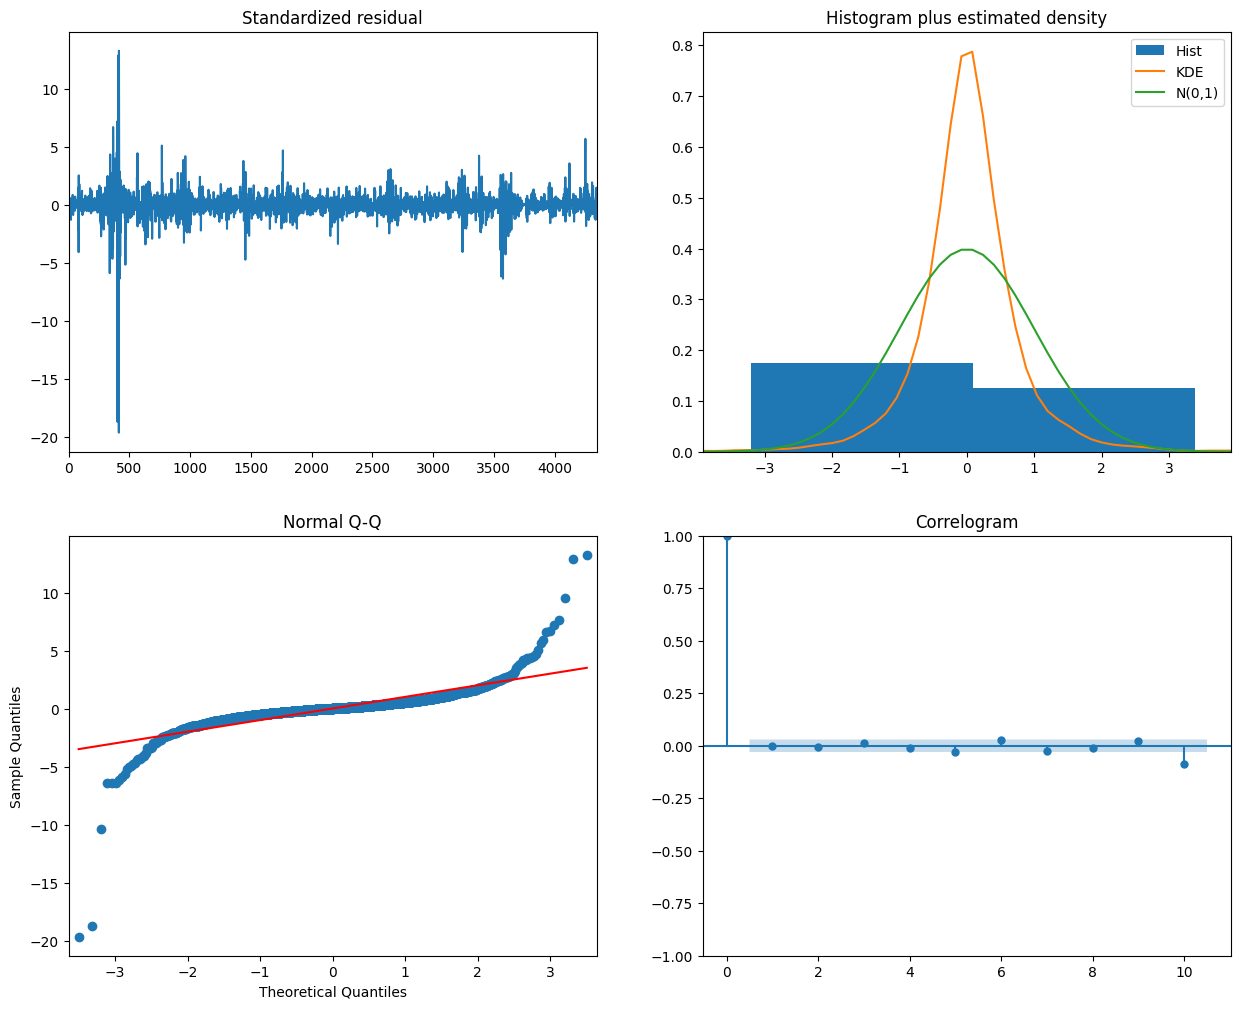

In [75]:
ARIMAX_model.plot_diagnostics(figsize=(15,12))
plt.show()

In [76]:
test_data_new

,Date,Arrival,Price
0,2021-11-29,252.000,6410.0
1,2021-11-30,150.830,6390.0
2,2021-12-01,202.880,6450.0
3,2021-12-02,228.450,6445.0
4,2021-12-03,174.300,6395.0
...,...,...,...
1083,2024-11-16,238.050,6475.0
1084,2024-11-17,234.558,6441.0
1085,2024-11-18,217.580,6450.0
1086,2024-11-19,306.980,6450.0


In [77]:
# df['Date'] = pd.to_datetime(df['Date'])

In [78]:
df['Date'] = pd.to_datetime(df['Date'])
train_data_new['Date'] = pd.to_datetime(train_data_new['Date'])
test_data_new['Date'] = pd.to_datetime(test_data_new['Date'])

In [79]:
from datetime import timedelta

In [80]:
# Make predictions on the training data
train_predictions_new, _ = ARIMAX_model.predict_in_sample(return_conf_int=True)

# Store the training predictions with dates
train_predictions_df_new = pd.DataFrame({'Date': train_data_new['Date'], 'Predicted_Price': train_predictions_new})
train_predictions_df_new.set_index('Date', inplace=True)

# Make predictions on the test data
test_predictions_new, conf_int =ARIMAX_model.predict(n_periods=len(test_data_new), return_conf_int=True)

# Store the test predictions with dates
test_predictions_df_new = pd.DataFrame({'Date': test_data_new['Date'], 'Predicted_Price': test_predictions_new})
test_predictions_df_new.set_index('Date', inplace=True)

# Forecast 10 steps ahead
forecast_steps = 100
forecast_new, conf_int_forecast =ARIMAX_model.predict(n_periods=forecast_steps, return_conf_int=True)

# Create a DataFrame for the forecasted values with future dates
future_dates = pd.date_range(df['Date'].max() + timedelta(days=1), periods=forecast_steps, freq='D')
forecast_df_new = pd.DataFrame({'Date': future_dates, 'Forecasted_Price': forecast_new})
forecast_df_new.set_index('Date', inplace=True)

In [81]:
forecast_df_new

,Forecasted_Price
Date,
2024-11-21,6430.061776
2024-11-22,6422.328827
2024-11-23,6415.939608
2024-11-24,6412.358394
2024-11-25,6413.624120
...,...
2025-02-24,6418.642934
2025-02-25,6418.643560
2025-02-26,6418.646232


In [82]:
test_predictions_df_new_list = test_predictions_df_new['Predicted_Price'].iloc[1088:].to_list().copy()

In [83]:
len(test_predictions_df_new_list)

1088

In [84]:
len(dates_list)

1088

In [85]:
data = {
    "Date": dates_list,
    "Predicted_Price": test_predictions_df_new_list
}

new_df = pd.DataFrame(data)
new_df.set_index('Date', inplace=True)
test_predictions_df_new=new_df.copy()

In [86]:
train_data_new['Date'] = pd.to_datetime(train_data_new['Date'])
test_data_new['Date'] = pd.to_datetime(test_data_new['Date'])
train_predictions_df_new.index = pd.to_datetime(train_predictions_df_new.index)
test_predictions_df_new.index = pd.to_datetime(test_predictions_df_new.index)
forecast_df_new.index = pd.to_datetime(forecast_df_new.index)

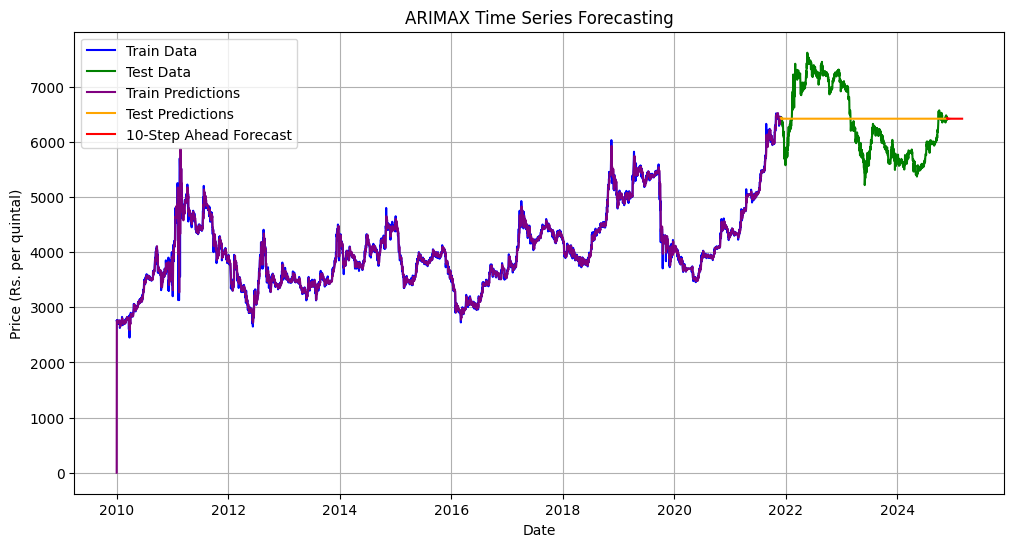

In [87]:
plt.figure(figsize=(12, 6))
plt.plot(train_data_new['Date'], train_data_new['Price'], label='Train Data', color='blue')
plt.plot(test_data_new['Date'], test_data_new['Price'], label='Test Data', color='green')
plt.plot(train_predictions_df_new.index, train_predictions_df_new['Predicted_Price'], label='Train Predictions', color='purple')
plt.plot(test_predictions_df_new.index, test_predictions_df_new['Predicted_Price'], label='Test Predictions', color='orange')
plt.plot(forecast_df_new.index, forecast_df_new['Forecasted_Price'], label='10-Step Ahead Forecast', color='red')
plt.xlabel('Date')
plt.ylabel('Price (Rs. per quintal)')
plt.legend()
plt.title('ARIMAX Time Series Forecasting')
plt.grid(True)
plt.show()

In [88]:
test_predictions_df_new

,Predicted_Price
Date,
2021-11-29,6430.061776
2021-11-30,6422.328827
2021-12-01,6415.939608
2021-12-02,6412.358394
2021-12-03,6413.624120
...,...
2024-11-16,6418.646678
2024-11-17,6418.646678
2024-11-18,6418.646678


In [89]:
from sklearn.metrics import mean_squared_error
import math
from statistics import mean

rmse_auto_arima=math.sqrt(mean_squared_error(test_predictions_df_new['Predicted_Price'],test_data_new['Price']))
print('Mean value of price is : {}. Root Mean Squared Error is :{}'.format(mean(test_data_new['Price']),rmse_auto_arima))

Mean value of price is : 6343.692662377451. Root Mean Squared Error is :648.066694997409


In [90]:
from sklearn.metrics import mean_squared_error
y_true = test_data_new["Price"]
y_pred = test_predictions_df_new

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

# Calculate the range of the target variable
y_range = np.max(y_true) - np.min(y_true)

# Calculate the RMSE as a percentage of the range
rmse_percentage = (rmse / y_range) * 100

print(f'Root Mean Squared Error (MSE) : {mse:.2f}')
print(f'Root Mean Squared Error (RMSE) : {rmse:.2f}')
print(f'Root Mean Squared Error (RMSE) as a percentage of the range: {rmse_percentage:.2f}%')

Root Mean Squared Error (MSE) : 419990.44
Root Mean Squared Error (RMSE) : 648.07
Root Mean Squared Error (RMSE) as a percentage of the range: 27.00%


In [93]:
# prompt: generate r2 score code

from sklearn.metrics import r2_score

r2 = r2_score(test_data_new["Price"], test_predictions_df_new['Predicted_Price'])
print(f"R-squared (R2) Score: {r2}")

R-squared (R2) Score: -0.013561896079521407


In [91]:
# Convert the 'Date' column to datetime format
test_data_new['Date'] = pd.to_datetime(test_data_new['Date'])

# Set 'Date' as the index for time series analysis
test_data_new.set_index('Date', inplace=True)

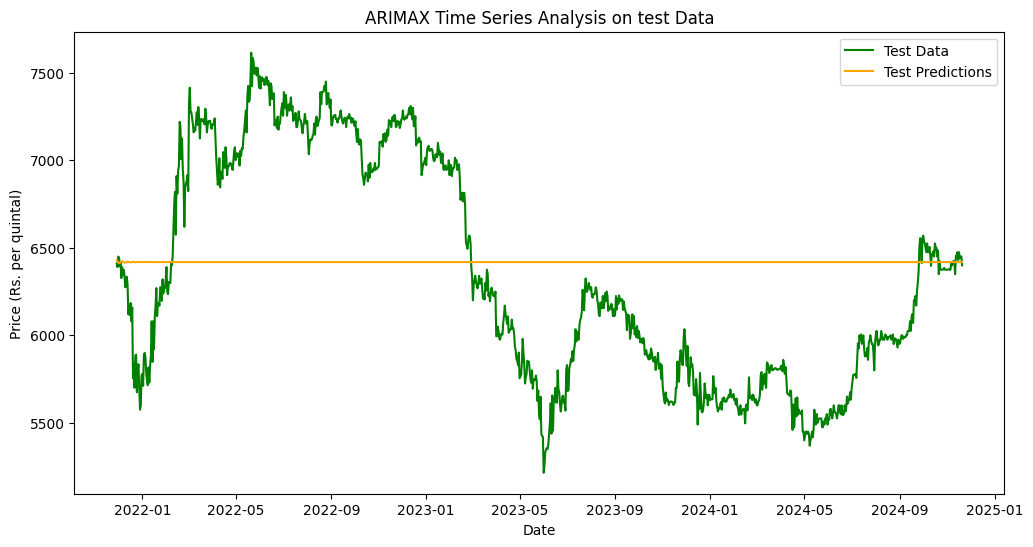

In [92]:
plt.figure(figsize=(12, 6))
plt.plot(test_data_new.index, test_data_new['Price'], label='Test Data', color='green')
plt.plot(test_predictions_df_new.index, test_predictions_df_new, label='Test Predictions', color='orange')
plt.xlabel('Date')
plt.ylabel('Price (Rs. per quintal)')
plt.legend()
plt.title('ARIMAX Time Series Analysis on test Data')
plt.show()